References:
- https://github.com/glotzerlab/hoomd-examples/blob/trunk-minor/01-Introducing-Molecular-Dynamics/00-index.ipynb


In [1]:
import sys
import os

import itertools
import math
import numpy as np

import hoomd
# import hoomd.md

import gsd
import gsd.hoomd

# see render.py file --need to download separately
#import render_sphere as render

from tqdm import tqdm

In [2]:
import warnings
import math
import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse('0.13.0')
FRESNEL_MAX_VERSION = packaging.version.parse('0.14.0')


def render(snapshot):
    if (
        'version' not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f'Unsupported fresnel version {fresnel.version.version} - expect errors.'
        )
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=0.5
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]), roughness=0.5
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [3]:
# set integrator
# dt = set step size
integrator = hoomd.md.Integrator(dt=0.005)

In [4]:
# set interparticle potential as LJ

cell = hoomd.md.nlist.Cell(buffer=0.4)
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 2.5
integrator.forces.append(lj)

In [5]:
# NVT runs for equilibration
nvt = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All(), thermostat=hoomd.md.methods.thermostats.Bussi(kT=1.5)
)
integrator.methods.append(nvt)

In [6]:
# set initial conditions--generate particle in a KxKxK 3D box

m = 4 # m = number of unit cell in each axis
N_particles = 4*m**3 # since we assume 2 particles per unit cell for BCC
spacing = 1.3
K = math.ceil(N_particles**(1 / 3))
L = K * spacing
x = np.linspace(-L / 2, L / 2, K, endpoint=False)
position = list(itertools.product(x, repeat=3))

frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = position[0:N_particles]
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [L, L, L, 0, 0, 0]

# add name for this particle type
frame.particles.types = ['A']

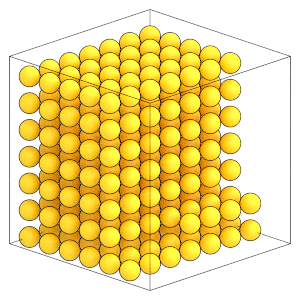

In [7]:
# import render_sphere as render
render(frame)

In [11]:
with gsd.hoomd.open(name='lattice.gsd', mode='x') as f:
    f.append(frame)

In [12]:
# initialize simulations
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=1)
simulation.create_state_from_gsd(filename='lattice.gsd')

In [13]:
integrator = hoomd.md.Integrator(dt=0.005)
cell = hoomd.md.nlist.Cell(buffer=0.4)
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 2.5
integrator.forces.append(lj)
nvt = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All(), thermostat=hoomd.md.methods.thermostats.Bussi(kT=1.5)
)
integrator.methods.append(nvt)

In [14]:
simulation.operations.integrator = integrator

In [15]:
# set initial temp to non-zero
simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(), kT=1.5)

In [16]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)

In [17]:
simulation.operations.computes.append(thermodynamic_properties)
simulation.run(0)

In [18]:
steps = 10000
delta = 1000
for i in range(np.int32(steps/delta)):
    simulation.run(delta)
    render(simulation.state.get_snapshot())

TypeError: 'module' object is not callable

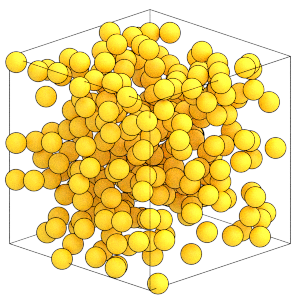

In [47]:
simulation.run(10000)
render(simulation.state.get_snapshot())